In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import Caltech101

torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

# fix seed
np.random.seed(0)

## Data

In [2]:
batch_size = 256
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)


dataset = Caltech101(root="./data", download=True, transform=train_transform)

# # split dataset
n_train = int(len(dataset) * 0.8)
n_val = len(dataset) - n_train

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [3]:
for data, target in testloader:
    print(data.shape)
    print(target)
    break

torch.Size([256, 3, 224, 224])
tensor([ 66,  61,  53,  35,  12,  23,  43,  60,   3,   3,   3,  72,   1,  19,
         91,  27,  79,  29,  78,  47,  29,  33,  76,   0,  78,   1,  81,  26,
         59,   2,   5,   3,   1,  60,   3,   3,  45,  96,  54,   0,  78,  96,
          3,  39,  40,  26,   0,   5,   5,  26,  87,  32,   3,   3,  96,  21,
          0,  74,  13,   0,  38,   3,  92,   2,  12,  30,   0,  61,  57,  26,
         65,  71,  49,  47,  60,  16,  92,  12,  74,  12,   2,  13,  68,  50,
         40,  67,  19,   0,  79,  65,   2,   3,   3,  37,  98,  60,  65,   5,
         91,  11,  73,   3,  75,  66,   1,  54,  81,   3,   5,  20,   3,   5,
          3,  52,  37,   2,  59,   9,   5,  85,   5,   5,  87,  85,  50,  94,
         32,   0,  14,  15,  94,  51,  90,  22,  33,   1,  62,   0,  33,   5,
         45,  75,  59,  50,  77,   2,  36,   5,  22,  78,  58,  87,   1,  54,
          3,   3,   2,   5,  75,  94,   5,   3,  10,   0,  30,   3,  16,  69,
         55,  44, 100,  90,  97, 

## Model

In [4]:
class GCN(nn.Module):
    def __init__(self, in_features, edge_features, out_feature, device, ratio=(1,)):
        super(GCN, self).__init__()

        self.edge_net = EdgeNet(
            in_features=in_features,
            num_features=edge_features,
            device=device,
            ratio=ratio,
        )
        # set edge to node
        self.node_net = NodeNet(
            in_features=in_features,
            num_features=out_feature,
            device=device,
            ratio=ratio,
        )
        # mask value for no-gradient edges
        self.mask_val = -1

    def label2edge(self, targets):
        """convert node labels to affinity mask for backprop"""
        num_sample = targets.size()[1]
        label_i = targets.unsqueeze(-1).repeat(1, 1, num_sample)
        label_j = label_i.transpose(1, 2)
        edge = torch.eq(label_i, label_j).float()
        target_edge_mask = (
            torch.eq(label_i, self.mask_val) + torch.eq(label_j, self.mask_val)
        ).type(torch.bool)
        source_edge_mask = ~target_edge_mask
        init_edge = edge * source_edge_mask.float()
        return init_edge[0], source_edge_mask

    def forward(self, init_node_feat):
        #  compute normalized and not normalized affinity matrix
        edge_feat, edge_sim = self.edge_net(init_node_feat)
        # compute node features and class logits
        logits_gnn = self.node_net(init_node_feat, edge_feat)
        return logits_gnn, edge_sim


class NodeNet(nn.Module):
    def __init__(self, in_features, num_features, device, ratio=(1,)):
        super(NodeNet, self).__init__()
        num_features_list = [num_features * r for r in ratio]
        self.device = device
        # define layers
        layer_list = OrderedDict()
        for l in range(len(num_features_list)):
            layer_list["conv{}".format(l)] = nn.Conv2d(
                in_channels=num_features_list[l - 1] if l > 0 else in_features * 2,
                out_channels=num_features_list[l],
                kernel_size=1,
                bias=False,
            )
            layer_list["norm{}".format(l)] = nn.BatchNorm2d(
                num_features=num_features_list[l]
            )
            if l < (len(num_features_list) - 1):
                layer_list["relu{}".format(l)] = nn.LeakyReLU()
        self.network = nn.Sequential(layer_list).to(device)

    def forward(self, node_feat, edge_feat):
        """node_feat: (bs, dim), edge_feat: (bs, bs)"""
        node_feat = node_feat.unsqueeze(dim=0)  # (1, bs, dim)
        num_tasks = node_feat.size(0)  # 1
        num_data = node_feat.size(1)  # bs
        # get eye matrix (batch_size x node_size x node_size) only use inter dist.
        diag_mask = 1.0 - torch.eye(num_data).unsqueeze(0).repeat(num_tasks, 1, 1).to(
            self.device
        )  # (1, bs, bs)
        # set diagonal as zero and normalize
        edge_feat = F.normalize(edge_feat * diag_mask, p=1, dim=-1)  # (bs, bs)
        # compute attention and aggregate
        aggr_feat = torch.bmm(edge_feat.squeeze(1), node_feat)  # (bs, dim)
        node_feat = torch.cat([node_feat, aggr_feat], -1).transpose(
            1, 2
        )  # (1, 2*dim, bs)
        # non-linear transform
        node_feat = self.network(node_feat.unsqueeze(-1)).transpose(
            1, 2
        )  # (1, bs, dim)
        node_feat = node_feat.squeeze(-1).squeeze(0)  # (bs, dim)
        return node_feat


class EdgeNet(nn.Module):
    def __init__(self, in_features, num_features, device, ratio=(1,)):
        super(EdgeNet, self).__init__()
        num_features_list = [num_features * r for r in ratio]
        self.device = device
        # define layers
        layer_list = OrderedDict()
        for l in range(len(num_features_list)):
            layer_list["conv{}".format(l)] = nn.Conv2d(
                in_channels=num_features_list[l - 1] if l > 0 else in_features,
                out_channels=num_features_list[l],
                kernel_size=1,
                bias=False,
            )
            layer_list["norm{}".format(l)] = nn.BatchNorm2d(
                num_features=num_features_list[l]
            )
            layer_list["relu{}".format(l)] = nn.LeakyReLU()
        # add final similarity kernel
        layer_list["conv_out"] = nn.Conv2d(
            in_channels=num_features_list[-1], out_channels=1, kernel_size=1
        )
        self.sim_network = nn.Sequential(layer_list).to(device)

    def forward(self, node_feat):
        node_feat = node_feat.unsqueeze(dim=0)  # (1, bs, dim)
        num_tasks = node_feat.size(0)  # 1
        num_data = node_feat.size(1)  # bs
        x_i = node_feat.unsqueeze(2)  # (1, bs, 1, dim)
        x_j = torch.transpose(x_i, 1, 2)  # (1, 1, bs, dim)
        x_ij = torch.abs(x_i - x_j)  # (1, bs, bs, dim)
        x_ij = torch.transpose(x_ij, 1, 3)  # (1, dim, bs, bs)
        # compute similarity/dissimilarity (batch_size x feat_size x num_samples x num_samples)
        sim_val = (
            torch.sigmoid(self.sim_network(x_ij)).squeeze(1).squeeze(0).to(self.device)
        )  # (bs, bs)
        # normalize affinity matrix
        force_edge_feat = (
            torch.eye(num_data).unsqueeze(0).repeat(num_tasks, 1, 1).to(self.device)
        )  # (1, bs, bs)
        edge_feat = sim_val + force_edge_feat  # (bs, bs)
        edge_feat = edge_feat + 1e-6  # add small value to avoid nan
        edge_feat = edge_feat / torch.sum(edge_feat, dim=1).unsqueeze(1)  # normalize
        return edge_feat, sim_val  # (bs, bs), (bs, bs)

In [5]:
from torchvision.models import mobilenet_v3_small


class Model(nn.Module):
    def __init__(self, num_classes=7):
        super(Model, self).__init__()
        self.backbone = mobilenet_v3_small(pretrained=True)
        self.backbone.classifier = nn.Sequential()

        self.gcn = GCN(
            in_features=576,
            edge_features=576,
            out_feature=num_classes,
            device="cuda",
            ratio=(1,),
        )

    def forward(self, x):
        x = self.backbone(x)
        x, edge_sim = self.gcn(x)
        return x, edge_sim

In [6]:
model = Model(num_classes=101).to(device)

/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
x = torch.randn(2, 3, 224, 224).to(device)
print(model(x)[0].shape)

torch.Size([2, 101])


# Train

In [8]:
criterion = nn.CrossEntropyLoss()
criterion_edge = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [9]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs, edge_sim = model(images)
            # Cls loss
            loss_cls = criterion(outputs, labels)

            # Edge loss
            edge_gt, edge_mask = model.gcn.label2edge(labels.unsqueeze(dim=0))
            loss_edge = criterion_edge(
                edge_sim.masked_select(edge_mask), edge_gt.masked_select(edge_mask)
            )

            # Total loss
            loss = 0.3 * loss_cls + loss_edge

            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [10]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 30

In [11]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0  # to track number of correct predictions
    total = 0  # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, edge_sim = model(inputs)

        # Cls loss
        loss_cls = criterion(outputs, labels)

        # Edge loss
        edge_gt, edge_mask = model.gcn.label2edge(labels.unsqueeze(dim=0))
        loss_edge = criterion_edge(
            edge_sim.masked_select(edge_mask), edge_gt.masked_select(edge_mask)
        )

        # Total loss
        loss = 0.3 * loss_cls + loss_edge

        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(
        f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%"
    )

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/ 30] 	 Loss: 1.68725     Accuracy: 19.35% 	 Test Loss: 1.47589     Test Accuracy: 34.22%
Epoch [  2/ 30] 	 Loss: 1.13364     Accuracy: 54.07% 	 Test Loss: 1.08453     Test Accuracy: 51.04%
Epoch [  3/ 30] 	 Loss: 0.84118     Accuracy: 70.21% 	 Test Loss: 0.85645     Test Accuracy: 62.50%
Epoch [  4/ 30] 	 Loss: 0.66854     Accuracy: 79.30% 	 Test Loss: 0.73769     Test Accuracy: 70.85%
Epoch [  5/ 30] 	 Loss: 0.55760     Accuracy: 84.70% 	 Test Loss: 0.63457     Test Accuracy: 77.94%
Epoch [  6/ 30] 	 Loss: 0.47375     Accuracy: 88.56% 	 Test Loss: 0.56384     Test Accuracy: 80.13%
Epoch [  7/ 30] 	 Loss: 0.41969     Accuracy: 90.77% 	 Test Loss: 0.52100     Test Accuracy: 83.12%
Epoch [  8/ 30] 	 Loss: 0.37344     Accuracy: 93.08% 	 Test Loss: 0.49551     Test Accuracy: 83.87%
Epoch [  9/ 30] 	 Loss: 0.33964     Accuracy: 94.27% 	 Test Loss: 0.46318     Test Accuracy: 84.85%
Epoch [ 10/ 30] 	 Loss: 0.31317     Accuracy: 95.35% 	 Test Loss: 0.44438     Test Accuracy: 85.08%


In [12]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(
    f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%"
)


Best epoch: 30 with test accuracy: 91.76%


# Plot results

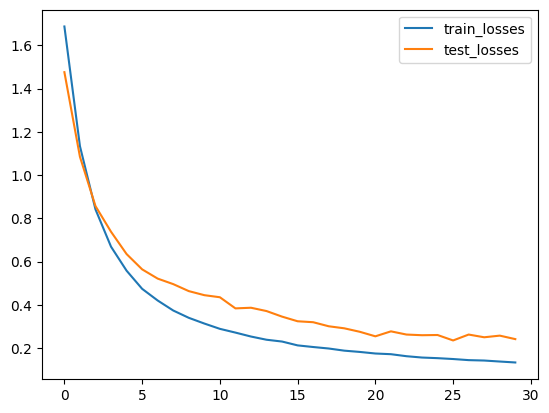

In [13]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()

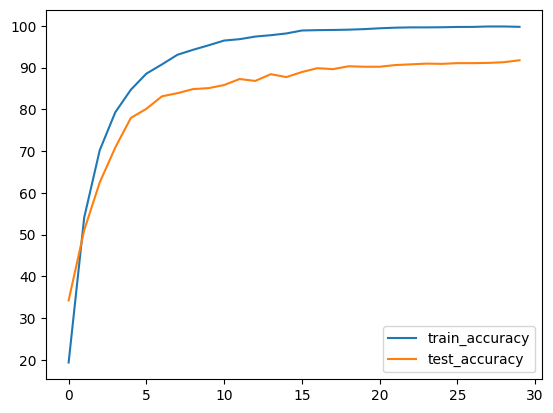

In [14]:
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(test_accuracies, label="test_accuracy")
plt.legend()